## Denoising the wavelet domain

### Add Noise to an Image at Given SNR

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
import pywt
from __future__ import division
from nt_toolbox.general import *
from nt_toolbox.signal import *
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

In [ ]:

# Load grayscale image and normalize
image = img_as_float(io.imread('data/barbara.jpg', as_gray=True))

In [6]:
def add_noise_snr(image, snr_db):
    signal_power = np.mean(image**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power), image.shape)
    return image + noise

In [7]:
noisy_0db = add_noise_snr(image, 0)
noisy_10db = add_noise_snr(image, 10)
noisy_20db = add_noise_snr(image, 20)

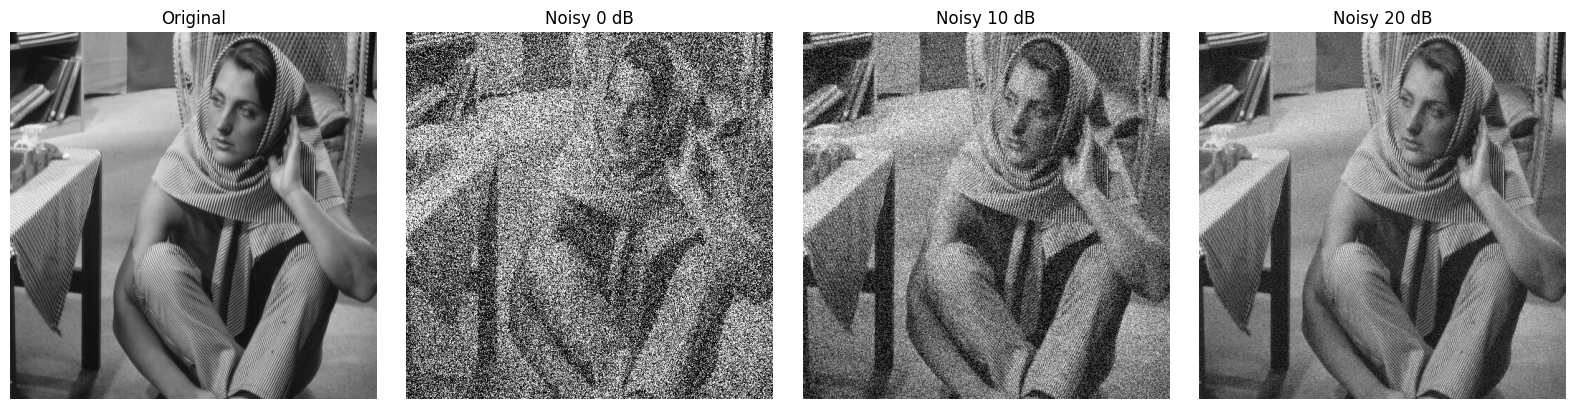

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
titles = ['Original', 'Noisy 0 dB', 'Noisy 10 dB', 'Noisy 20 dB']
images = [image, noisy_0db, noisy_10db, noisy_20db]

for ax, img, title in zip(axs, images, titles):
    ax.imshow(np.clip(img, 0, 1), cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

### Hard and Soft Thresholding

The difference between hard and soft is similar to the difference between Lasso and Ridge.

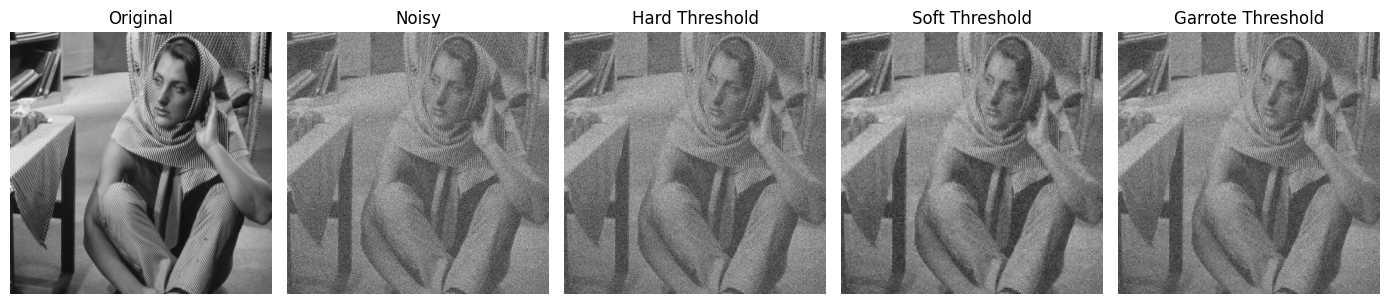

In [19]:
i = 2
f = images[i]
# Perform 2D wavelet decomposition
wavelet = 'db1'
coeffs = pywt.wavedec2(f, wavelet, level=2)

# Thresholding function
def apply_threshold(coeffs, T, mode='hard'):
    cA, detail = coeffs[0], coeffs[1:]
    new_detail = []
    for (cH, cV, cD) in detail:
        new_detail.append((
            pywt.threshold(cH, T, mode=mode),
            pywt.threshold(cV, T, mode=mode),
            pywt.threshold(cD, T, mode=mode)))
    return [cA] + new_detail

# Apply both methods
T = 0.1
coeffs_hard = apply_threshold(coeffs, T, 'hard')
coeffs_soft = apply_threshold(coeffs, T, 'soft')
coeffs_garrote = apply_threshold(coeffs, T, 'garrote')

# Reconstruct images
denoised_hard = pywt.waverec2(coeffs_hard, wavelet)
denoised_soft = pywt.waverec2(coeffs_soft, wavelet)
denoised_garrote = pywt.waverec2(coeffs_garrote, wavelet)

# Display
fig, axs = plt.subplots(1, 5, figsize=(14, 5))
titles = ['Original', 'Noisy', 'Hard Threshold', 'Soft Threshold', 'Garrote Threshold']
imgs = [images[0], f, denoised_hard, denoised_soft, denoised_garrote]
for ax, img, title in zip(axs, imgs, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()


Parameters to optimise:

- wavelet type
- number of level
- type of thresholding

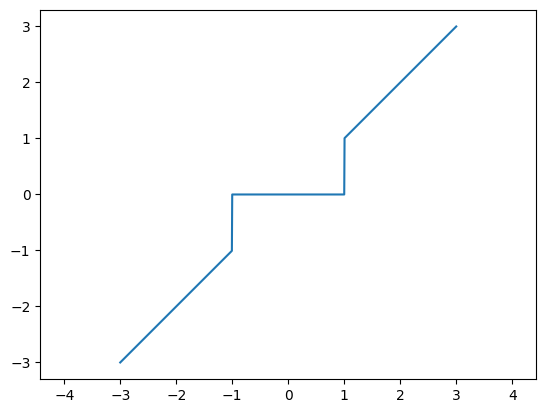

In [38]:
f = images[i]
f0 = images[0]

def thresh_hard(u,t):return u*(abs(u)>t)
alpha = linspace(-3,3,1000)
plot(alpha, thresh_hard(alpha,1))
axis('equal');

Parameters for the orthogonal wavelet transform

In [39]:
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
h = h/norm(h)
Jmin = 2

First we compute the wavelet coefficients a
of the noisy image f.

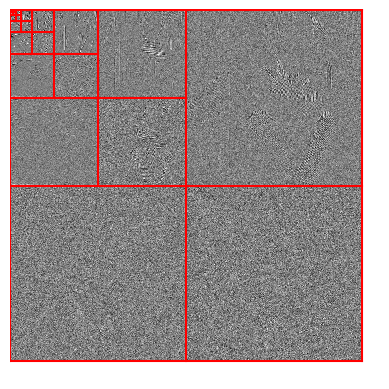

In [40]:
a = perform_wavortho_transf(f,Jmin,+1,h)
plot_wavelet(a,Jmin);

Select the threshold value, that should be proportional to the noise level σ.

Hard threshold the coefficients below the noise level to obtain aT(m)=s0T(am).

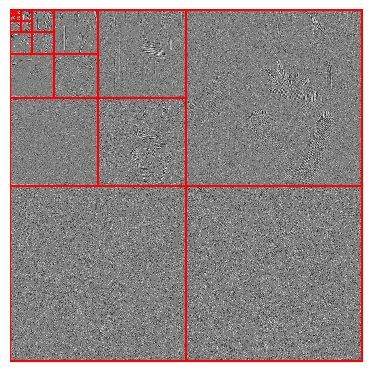

In [41]:
sigma = 0.05
T = 3*sigma
aT = thresh_hard(a,T)
plot_wavelet(aT,Jmin);

Reconstruct the image f~ from these noisy coefficients.

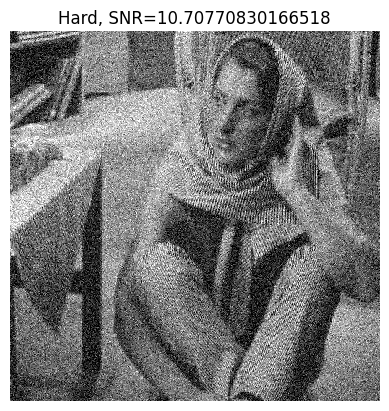

In [42]:
fHard = perform_wavortho_transf(aT,Jmin,-1,h)
imageplot(clamp(fHard), 'Hard, SNR=' + str(snr(f0,fHard)) )

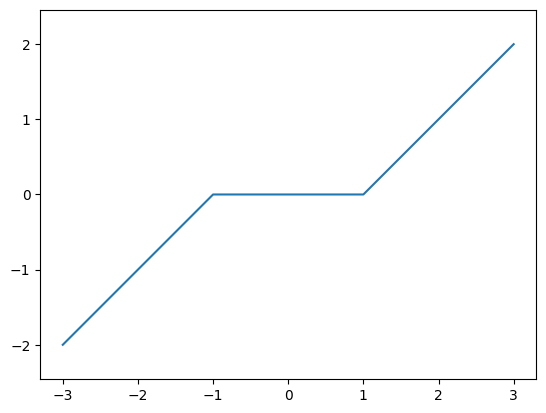

In [43]:
def thresh_soft(u,t):return maximum(1-t/abs(u), 0)*u
alpha = linspace(-3,3,1000)
plot(alpha, thresh_soft(alpha,1))
axis('equal');

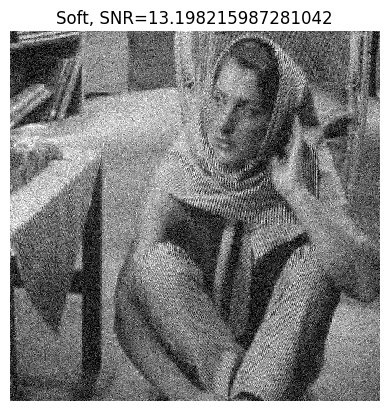

In [44]:
T = 3/2*sigma
aT = thresh_soft(a,T)
aT[:2^Jmin:,:2^Jmin:] = a[:2^Jmin:,:2^Jmin:]
fSoft = perform_wavortho_transf(aT,Jmin,-1,h)
imageplot(clamp(fSoft), 'Soft, SNR=' + str(snr(f0,fSoft)) )

#### Translation Invariant Denoising with Cycle Spinning

Orthogonal wavelet transforms are not translation invariant. It means that the processing of an image and of a translated version of the image give different results.

Any denoiser can be turned into a translation invariant denoiser by performing a cycle spinning. The denoiser is applied to several shifted copies of the image, then the resulting denoised image are shifted back to the original position, and the results are averaged.

This corresponds to defining the estimator as
f~=1M∑i=1M$T−δi∘ST(f)∘Tδi
where ST is either the hard or soft thresholding, and Tδ(f)(x)=f(x−δ) is the translation operator, using periodic boundary conditions. Here (δi)i is a set of M discrete translation. Perfect invariance is obtained by using all possible N translatation, but usually a small number M≪N

of translation is used to obtain approximate invariance.

Number m
of translations along each direction so that M=m2.

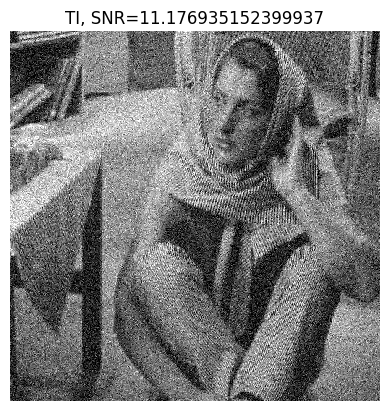

In [ ]:
n = f.shape[0]
m = 4
[dY,dX] = meshgrid(arange(0,m),arange(0,m))
delta = concatenate( (dX.reshape(m*m,1), dY.reshape(m*m,1)), axis=1)


fTI = zeros([n,n])
T = 3*sigma
for i in arange(0,m*m):
    fS = circshift(f,delta[i,:])
    a = perform_wavortho_transf(fS,Jmin,1,h)
    aT = thresh_hard(a,T)
    fS = perform_wavortho_transf(aT,Jmin,-1,h)
    fS = circshift(fS,-delta[i,:])
    fTI = i/(i+1.0)*fTI + 1.0/(i+1)*fS


imageplot(clamp(fTI), 'TI, SNR=' + str(snr(f0,fTI)) )

In [51]:
def TIDCS(f, m=4, T = 0.15):
    n = f.shape[0]
    [dY, dX] = meshgrid(arange(0, m), arange(0, m))
    delta = concatenate((dX.reshape(m * m, 1), dY.reshape(m * m, 1)), axis=1)
    
    fTI = zeros([n, n])
    for i in arange(0, m * m):
        fS = circshift(f, delta[i, :])
        a = perform_wavortho_transf(fS, Jmin, 1, h)
        aT = thresh_hard(a, T)
        fS = perform_wavortho_transf(aT, Jmin, -1, h)
        fS = circshift(fS, -delta[i, :])
        fTI = i / (i + 1.0) * fTI + 1.0 / (i + 1) * fS
    
    return clamp(fTI)

In [ ]:
# Study the influence of the number m of shift on the denoising quality
M = [1, 2, 4, 8]
FTI = []
SNRs = []

for m in M:
    fTI = TIDCS(f, m)
    FTI.append(fTI)
    SNRs.append(snr(f0, fTI))

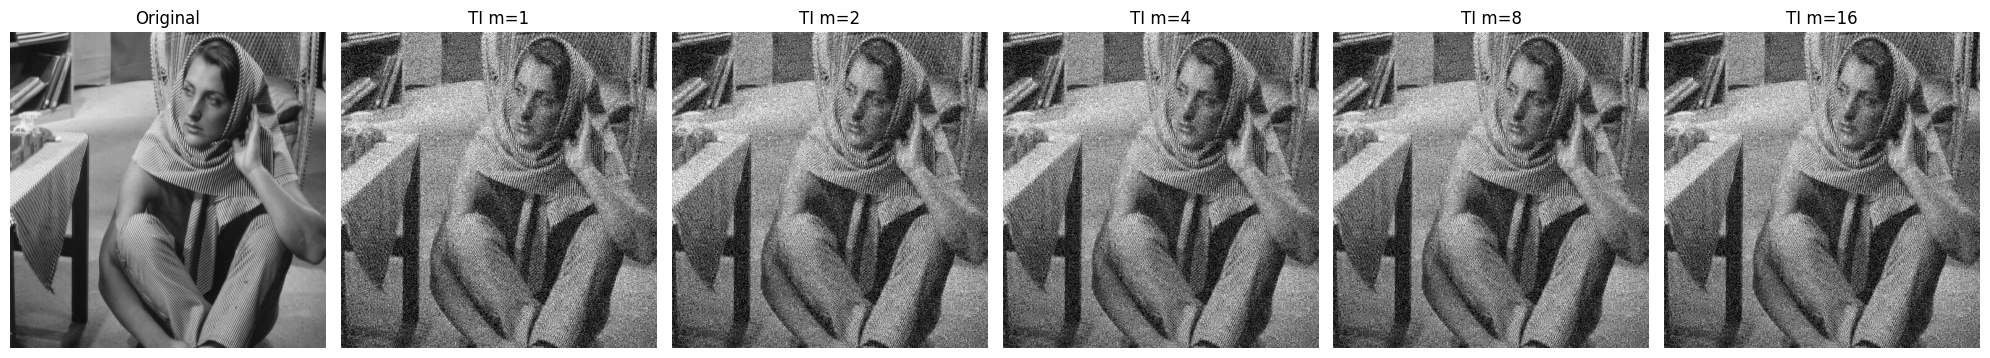

SNR for m=1: 10.95 dB
SNR for m=2: 11.34 dB
SNR for m=4: 11.40 dB
SNR for m=8: 11.40 dB
SNR for m=16: 11.41 dB


In [54]:
# Display results
fig, axs = plt.subplots(1, len(M) + 1, figsize=(20, 4))
titles = ['Original'] + [f'TI m={m}' for m in M]
for ax, img, title in zip(axs, [f0] + FTI, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()
for i, snr_value in enumerate(SNRs):
    print(f'SNR for m={M[i]}: {snr_value:.2f} dB')

The change with different value for m are minimal. Let's go back once the treshold value is optimised.

In [55]:
# Find the optimal threshold value
thresholds = linspace(0.01, 0.5, 50)
snrs = []

for T in thresholds:
    fTI = TIDCS(f, m=4, T=T)
    snrs.append(snr(f0, fTI))


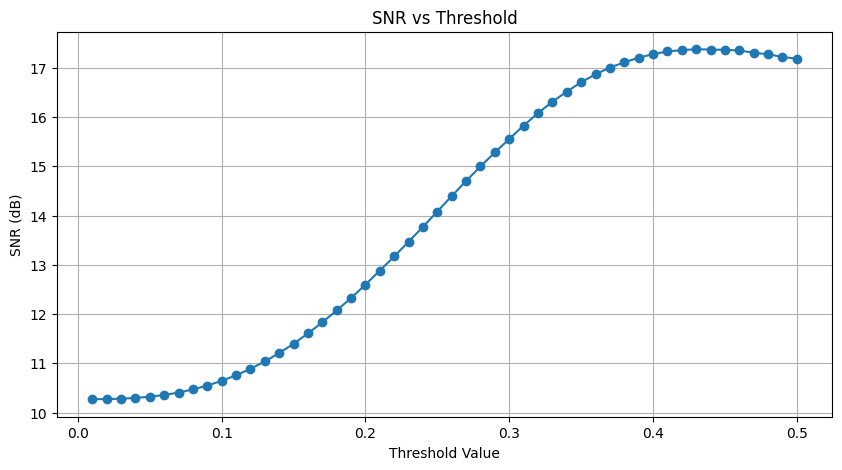

In [57]:
# Plot SNR vs Threshold
plt.figure(figsize=(10, 5))
plt.plot(thresholds, snrs, marker='o')
plt.title('SNR vs Threshold')
plt.xlabel('Threshold Value')
plt.ylabel('SNR (dB)')
plt.grid()
plt.show()

The good treeshold value seem to be T = 0.43

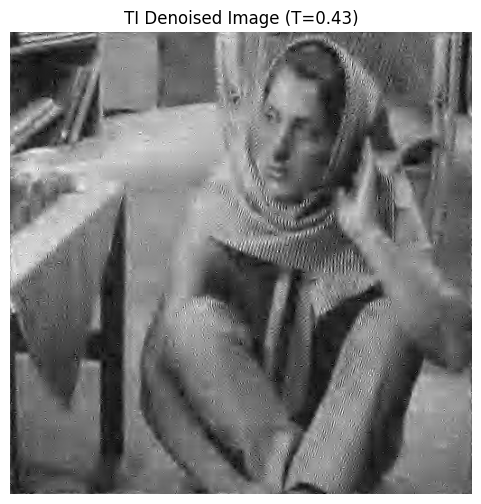

In [58]:
T = 0.43  # Optimal threshold value based on the previous analysis
# Display the denoised image with the optimal threshold
fTI_optimal = TIDCS(f, m=4, T=T)
plt.figure(figsize=(6, 6))
plt.imshow(fTI_optimal, cmap='gray')
plt.title(f'TI Denoised Image (T={T})')
plt.axis('off')
plt.show()

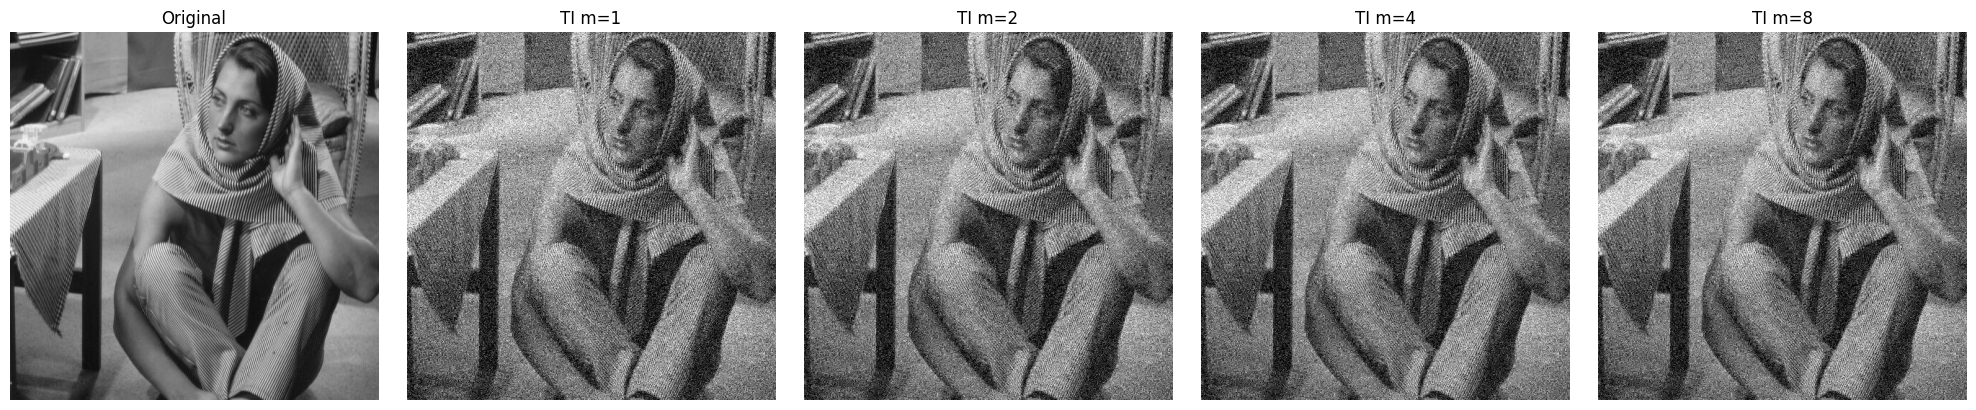

SNR for m=1: 10.95 dB
SNR for m=2: 11.34 dB
SNR for m=4: 11.40 dB
SNR for m=8: 11.40 dB


In [59]:
# Optimisation of m number of shift
M = [1, 2, 4, 8]
FTI = []
SNRs = []
for m in M:
    fTI = TIDCS(f, m)
    FTI.append(fTI)
    SNRs.append(snr(f0, fTI))
# Display results
fig, axs = plt.subplots(1, len(M) + 1, figsize=(20, 4))
titles = ['Original'] + [f'TI m={m}' for m in M]
for ax, img, title in zip(axs, [f0] + FTI, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()
for i, snr_value in enumerate(SNRs):
    print(f'SNR for m={M[i]}: {snr_value:.2f} dB')

The conclusion seem to show that the less shift the better.